In [4]:
import os;
os.environ['CUDA_VISIBLE_DEVICES']="0"
import numpy as np
print(os.environ['CUDA_VISIBLE_DEVICES'])

0


# Change these variables to suit your case 

In [5]:
# Choose label to train model ['MI', 'NORM', 'CD', 'STTC', 'HYP']
label = 'NORM'

# Define batch size
batch_size = 16*1024

# Define variables for early stopping
best_epoch = 0
patience = 10  # Number of epochs to wait for improvement
patience_counter = patience
MAX_EPOCHS = 50  # Maximum number of epochs
best_f1 = 0  # Early stopping metric

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter

# Load train data
Dataset = pd.read_csv('PTB_XL_Dataset.csv')  

# Split into features and labels
X_train = Dataset.iloc[:, :187]  
y_train = Dataset.loc[:, label]  

# Split the data into train and test sets, maintaining the same label distribution
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=50)

# Split the data into train and validation sets, maintaining the same label distribution
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=50)

# Change Data to numpy array
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Reshape data for tensors
X_train_reshaped = X_train_resampled.reshape(-1, 1, 187)
X_val_reshaped = X_val.reshape(-1, 1, 187)
X_test_reshaped = X_test.reshape(-1, 1, 187)
y_train_reshaped = y_train_resampled.reshape(-1, 1, 1)
y_val_reshaped = y_val.reshape(-1, 1, 1)
y_test_reshaped = y_test.reshape(-1, 1, 1)

In [7]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, filters, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(filters, filters, kernel_size, padding='same')
        self.conv2 = nn.Conv1d(filters, filters, kernel_size, padding='same')
        self.activation = nn.ReLU()
        self.max_pooling = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.activation(out)
        out = self.conv2(out)
        out += residual  # Residual connection
        out = self.activation(out)
        out = self.max_pooling(out)
        return out

class ConvResNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(ConvResNet, self).__init__()
        self.conv1 = nn.Conv1d(input_shape[0], 32, 5, padding='same')
        self.activation = nn.ReLU()
        self.residual_blocks = nn.ModuleList([ResidualBlock(32, 5) for _ in range(5)])
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        for block in self.residual_blocks:
            x = block(x)
        x = self.flatten(x)
        return x

# Define input shape (assuming each beat is a 1D signal with a certain length)
input_shape = (1, 187) 
num_classes = 5 
model1 = ConvResNet(input_shape, num_classes)

# Print model summary
print(model1)


ConvResNet(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=same)
  (activation): ReLU()
  (residual_blocks): ModuleList(
    (0-4): 5 x ResidualBlock(
      (conv1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=same)
      (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=same)
      (activation): ReLU()
      (max_pooling): MaxPool1d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=False)
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [8]:
# Load the saved model weights
model1.load_state_dict(torch.load('pretrained_weights.pth'), strict=False)


# Assuming model1 is your pretrained model
pretrained_model = model1

# Define new layers to add for fine-tuning
num_fine_tune_features = 192
fine_tune_layers = nn.Sequential(
    nn.Linear(num_fine_tune_features, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
)

class ModifiedModel(nn.Module):
    def __init__(self, existing_model, new_layers):
        super(ModifiedModel, self).__init__()
        self.existing_model = existing_model
        self.new_layers = new_layers

    def forward(self, x):
        x = self.existing_model(x)
        x = self.new_layers(x)
        return x
model = ModifiedModel(pretrained_model, fine_tune_layers)
print(model)

ModifiedModel(
  (existing_model): ConvResNet(
    (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=same)
    (activation): ReLU()
    (residual_blocks): ModuleList(
      (0-4): 5 x ResidualBlock(
        (conv1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=same)
        (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=same)
        (activation): ReLU()
        (max_pooling): MaxPool1d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=False)
      )
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (new_layers): Sequential(
    (0): Linear(in_features=192, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [9]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Convert data to PyTorch tensors
train_data_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
train_labels_tensor = torch.tensor(y_train_reshaped, dtype=torch.float32)
val_data_tensor = torch.tensor(X_val_reshaped, dtype=torch.float32)
val_labels_tensor = torch.tensor(y_val_reshaped, dtype=torch.float32)

# Move data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data_tensor = train_data_tensor.to(device)
train_labels_tensor = train_labels_tensor.to(device)
val_data_tensor = val_data_tensor.to(device)
val_labels_tensor = val_labels_tensor.to(device)

# Define dataset
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_data_tensor, val_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size)

# Move model to GPU
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))  # Adam optimizer with specified betas

# Define learning rate scheduler
scheduler = ExponentialLR(optimizer, gamma=0.99)  # Learning rate decay with a decay factor of 0.99

# Train the model
for epoch in range(MAX_EPOCHS):
    model.train()  # Set model to training mode
    train_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{MAX_EPOCHS}", unit="batch")
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        labels = torch.squeeze(labels, dim=1)
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        train_loss += loss.item()
        # Apply sigmoid function to logits
        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities > 0.5).cpu().numpy().astype(int)
        total += labels.size(0)
        correct += (predicted == labels.cpu().numpy()).sum()
        pbar.set_postfix(loss=train_loss / len(train_loader), acc=(correct / total) * 100)

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            true_labels.extend(labels.cpu().numpy())
            outputs = model(inputs)  # Forward pass
            labels = torch.squeeze(labels, dim=1)
            loss = criterion(outputs , labels)
            val_loss += loss.item()
            train_loss += loss.item()
            # Apply sigmoid function to logits
            probabilities = torch.sigmoid(outputs)
            predicted = (probabilities > 0.5).cpu().numpy().astype(int)
            total += labels.size(0)
            correct += (predicted == labels.cpu().numpy()).sum()
            predicted_labels.extend(predicted)
        avg_val_loss = val_loss / len(val_loader)
        f1 = f1_score(np.concatenate(true_labels),np.concatenate(predicted_labels) ,average='binary')
    if f1 > best_f1:
        best_f1 = f1
        best_epoch = epoch
        patience_counter = patience
        torch.save(model.state_dict(), 'best_model_'+label+'.pth')  # Save the model parameters
    else:
        patience_counter -= 1
        if patience_counter == 0:
            print(f"Validation loss did not improve for {patience} epochs. Early stopping.")
            break

    # Learning rate scheduling
    scheduler.step()

    # Print progress
    print(f"Epoch [{epoch+1}/{MAX_EPOCHS}], Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {(correct/total)*100:.2f}%, min f1: {f1:.4f}")

# Load the best model parameters
model.load_state_dict(torch.load('best_model_'+label+'.pth'))



Epoch 1/50: 100%|██████████| 8/8 [00:05<00:00,  1.55batch/s, acc=59.3, loss=0.91] 


Epoch [1/50], Train Loss: 1.0580, Val Loss: 0.5933, Val Acc: 68.13%, min f1: 0.6527


Epoch 2/50: 100%|██████████| 8/8 [00:04<00:00,  1.88batch/s, acc=72.2, loss=0.551] 


Epoch [2/50], Train Loss: 0.6780, Val Loss: 0.5081, Val Acc: 74.75%, min f1: 0.7158


Epoch 3/50: 100%|██████████| 8/8 [00:04<00:00,  1.86batch/s, acc=77, loss=0.488]   


Epoch [3/50], Train Loss: 0.6069, Val Loss: 0.4742, Val Acc: 76.87%, min f1: 0.7378


Epoch 4/50: 100%|██████████| 8/8 [00:04<00:00,  1.89batch/s, acc=79.6, loss=0.447] 


Epoch [4/50], Train Loss: 0.5584, Val Loss: 0.4470, Val Acc: 78.77%, min f1: 0.7606


Epoch 5/50: 100%|██████████| 8/8 [00:04<00:00,  1.88batch/s, acc=81.8, loss=0.414] 


Epoch [5/50], Train Loss: 0.5161, Val Loss: 0.4076, Val Acc: 82.06%, min f1: 0.7818


Epoch 6/50: 100%|██████████| 8/8 [00:04<00:00,  1.96batch/s, acc=83.1, loss=0.391] 


Epoch [6/50], Train Loss: 0.4888, Val Loss: 0.3901, Val Acc: 82.94%, min f1: 0.7937


Epoch 7/50: 100%|██████████| 8/8 [00:04<00:00,  1.90batch/s, acc=83.9, loss=0.374] 


Epoch [7/50], Train Loss: 0.4673, Val Loss: 0.3746, Val Acc: 83.55%, min f1: 0.8021


Epoch 8/50: 100%|██████████| 8/8 [00:04<00:00,  1.89batch/s, acc=84.5, loss=0.361] 


Epoch [8/50], Train Loss: 0.4565, Val Loss: 0.3820, Val Acc: 83.05%, min f1: 0.8029


Epoch 9/50: 100%|██████████| 8/8 [00:04<00:00,  1.90batch/s, acc=84.9, loss=0.355] 


Epoch [9/50], Train Loss: 0.4435, Val Loss: 0.3554, Val Acc: 84.25%, min f1: 0.8067


Epoch 10/50: 100%|██████████| 8/8 [00:04<00:00,  1.95batch/s, acc=85.2, loss=0.349] 


Epoch [10/50], Train Loss: 0.4372, Val Loss: 0.3531, Val Acc: 84.36%, min f1: 0.8095


Epoch 11/50: 100%|██████████| 8/8 [00:04<00:00,  1.77batch/s, acc=85.3, loss=0.344] 


Epoch [11/50], Train Loss: 0.4319, Val Loss: 0.3514, Val Acc: 84.45%, min f1: 0.8120


Epoch 12/50: 100%|██████████| 8/8 [00:04<00:00,  1.76batch/s, acc=85.6, loss=0.339] 


Epoch [12/50], Train Loss: 0.4275, Val Loss: 0.3543, Val Acc: 84.35%, min f1: 0.8142


Epoch 13/50: 100%|██████████| 8/8 [00:04<00:00,  1.78batch/s, acc=85.7, loss=0.336] 


Epoch [13/50], Train Loss: 0.4224, Val Loss: 0.3457, Val Acc: 84.63%, min f1: 0.8136


Epoch 14/50: 100%|██████████| 8/8 [00:04<00:00,  1.84batch/s, acc=85.9, loss=0.333] 


Epoch [14/50], Train Loss: 0.4183, Val Loss: 0.3399, Val Acc: 84.92%, min f1: 0.8141


Epoch 15/50: 100%|██████████| 8/8 [00:04<00:00,  1.77batch/s, acc=86, loss=0.331]   


Epoch [15/50], Train Loss: 0.4165, Val Loss: 0.3419, Val Acc: 84.85%, min f1: 0.8167


Epoch 16/50: 100%|██████████| 8/8 [00:04<00:00,  1.77batch/s, acc=85.9, loss=0.331] 


Epoch [16/50], Train Loss: 0.4181, Val Loss: 0.3482, Val Acc: 84.48%, min f1: 0.8165


Epoch 17/50: 100%|██████████| 8/8 [00:04<00:00,  1.78batch/s, acc=86, loss=0.328]  


Epoch [17/50], Train Loss: 0.4189, Val Loss: 0.3619, Val Acc: 83.93%, min f1: 0.8146


Epoch 18/50: 100%|██████████| 8/8 [00:04<00:00,  1.84batch/s, acc=86.1, loss=0.325]


Epoch [18/50], Train Loss: 0.4124, Val Loss: 0.3480, Val Acc: 84.49%, min f1: 0.8178


Epoch 19/50: 100%|██████████| 8/8 [00:04<00:00,  1.78batch/s, acc=86.4, loss=0.321] 


Epoch [19/50], Train Loss: 0.4055, Val Loss: 0.3367, Val Acc: 85.16%, min f1: 0.8208


Epoch 20/50: 100%|██████████| 8/8 [00:04<00:00,  1.78batch/s, acc=86.5, loss=0.318] 


Epoch [20/50], Train Loss: 0.4035, Val Loss: 0.3400, Val Acc: 84.87%, min f1: 0.8198


Epoch 21/50: 100%|██████████| 8/8 [00:04<00:00,  1.90batch/s, acc=86.5, loss=0.318] 


Epoch [21/50], Train Loss: 0.4018, Val Loss: 0.3344, Val Acc: 85.28%, min f1: 0.8223


Epoch 22/50: 100%|██████████| 8/8 [00:04<00:00,  1.98batch/s, acc=86.6, loss=0.317] 


Epoch [22/50], Train Loss: 0.3996, Val Loss: 0.3305, Val Acc: 85.49%, min f1: 0.8234


Epoch 23/50: 100%|██████████| 8/8 [00:04<00:00,  1.90batch/s, acc=86.6, loss=0.315] 


Epoch [23/50], Train Loss: 0.4022, Val Loss: 0.3505, Val Acc: 84.43%, min f1: 0.8189


Epoch 24/50: 100%|██████████| 8/8 [00:04<00:00,  1.88batch/s, acc=86.6, loss=0.315] 


Epoch [24/50], Train Loss: 0.3965, Val Loss: 0.3260, Val Acc: 85.67%, min f1: 0.8227


Epoch 25/50: 100%|██████████| 8/8 [00:04<00:00,  1.88batch/s, acc=86.7, loss=0.313] 


Epoch [25/50], Train Loss: 0.4007, Val Loss: 0.3516, Val Acc: 84.34%, min f1: 0.8189


Epoch 26/50: 100%|██████████| 8/8 [00:04<00:00,  1.97batch/s, acc=86.6, loss=0.313] 


Epoch [26/50], Train Loss: 0.3943, Val Loss: 0.3241, Val Acc: 85.67%, min f1: 0.8170


Epoch 27/50: 100%|██████████| 8/8 [00:04<00:00,  1.91batch/s, acc=86.6, loss=0.314] 


Epoch [27/50], Train Loss: 0.4006, Val Loss: 0.3447, Val Acc: 84.69%, min f1: 0.8212


Epoch 28/50: 100%|██████████| 8/8 [00:04<00:00,  1.89batch/s, acc=86.8, loss=0.311] 


Epoch [28/50], Train Loss: 0.3945, Val Loss: 0.3352, Val Acc: 85.03%, min f1: 0.8228


Epoch 29/50: 100%|██████████| 8/8 [00:04<00:00,  1.90batch/s, acc=86.9, loss=0.309] 


Epoch [29/50], Train Loss: 0.3893, Val Loss: 0.3223, Val Acc: 85.85%, min f1: 0.8253


Epoch 30/50: 100%|██████████| 8/8 [00:04<00:00,  1.97batch/s, acc=87, loss=0.307]   


Epoch [30/50], Train Loss: 0.3901, Val Loss: 0.3340, Val Acc: 85.13%, min f1: 0.8237


Epoch 31/50: 100%|██████████| 8/8 [00:04<00:00,  1.90batch/s, acc=87, loss=0.305]   


Epoch [31/50], Train Loss: 0.3856, Val Loss: 0.3212, Val Acc: 85.93%, min f1: 0.8263


Epoch 32/50: 100%|██████████| 8/8 [00:04<00:00,  1.90batch/s, acc=87, loss=0.306]   


Epoch [32/50], Train Loss: 0.3887, Val Loss: 0.3304, Val Acc: 85.28%, min f1: 0.8247


Epoch 33/50: 100%|██████████| 8/8 [00:04<00:00,  1.88batch/s, acc=87, loss=0.306]   


Epoch [33/50], Train Loss: 0.3897, Val Loss: 0.3355, Val Acc: 85.07%, min f1: 0.8236


Epoch 34/50: 100%|██████████| 8/8 [00:04<00:00,  1.89batch/s, acc=87.1, loss=0.303] 


Epoch [34/50], Train Loss: 0.3841, Val Loss: 0.3254, Val Acc: 85.57%, min f1: 0.8262


Epoch 35/50: 100%|██████████| 8/8 [00:04<00:00,  1.97batch/s, acc=87.2, loss=0.302] 


Epoch [35/50], Train Loss: 0.3820, Val Loss: 0.3211, Val Acc: 85.84%, min f1: 0.8272


Epoch 36/50: 100%|██████████| 8/8 [00:04<00:00,  1.85batch/s, acc=87.2, loss=0.301] 


Epoch [36/50], Train Loss: 0.3810, Val Loss: 0.3214, Val Acc: 85.79%, min f1: 0.8269


Epoch 37/50: 100%|██████████| 8/8 [00:04<00:00,  1.89batch/s, acc=87.2, loss=0.3]   


Epoch [37/50], Train Loss: 0.3806, Val Loss: 0.3216, Val Acc: 85.75%, min f1: 0.8273


Epoch 38/50: 100%|██████████| 8/8 [00:04<00:00,  1.87batch/s, acc=87.3, loss=0.299] 


Epoch [38/50], Train Loss: 0.3823, Val Loss: 0.3317, Val Acc: 85.33%, min f1: 0.8259


Epoch 39/50: 100%|██████████| 8/8 [00:04<00:00,  1.90batch/s, acc=87.3, loss=0.298] 


Epoch [39/50], Train Loss: 0.3784, Val Loss: 0.3214, Val Acc: 85.76%, min f1: 0.8275


Epoch 40/50: 100%|██████████| 8/8 [00:04<00:00,  1.88batch/s, acc=87.4, loss=0.297] 


Epoch [40/50], Train Loss: 0.3763, Val Loss: 0.3184, Val Acc: 85.92%, min f1: 0.8280


Epoch 41/50: 100%|██████████| 8/8 [00:04<00:00,  1.91batch/s, acc=87.3, loss=0.298] 


Epoch [41/50], Train Loss: 0.3770, Val Loss: 0.3178, Val Acc: 85.90%, min f1: 0.8279


Epoch 42/50: 100%|██████████| 8/8 [00:04<00:00,  1.89batch/s, acc=87.4, loss=0.296] 


Epoch [42/50], Train Loss: 0.3777, Val Loss: 0.3287, Val Acc: 85.39%, min f1: 0.8264


Epoch 43/50: 100%|██████████| 8/8 [00:04<00:00,  1.98batch/s, acc=87.4, loss=0.296] 


Epoch [43/50], Train Loss: 0.3774, Val Loss: 0.3260, Val Acc: 85.52%, min f1: 0.8271


Epoch 44/50: 100%|██████████| 8/8 [00:04<00:00,  1.89batch/s, acc=87.3, loss=0.298] 


Epoch [44/50], Train Loss: 0.3761, Val Loss: 0.3134, Val Acc: 86.19%, min f1: 0.8249


Epoch 45/50: 100%|██████████| 8/8 [00:04<00:00,  1.89batch/s, acc=87.2, loss=0.301] 


Epoch [45/50], Train Loss: 0.3844, Val Loss: 0.3338, Val Acc: 85.17%, min f1: 0.8261


Epoch 46/50: 100%|██████████| 8/8 [00:04<00:00,  1.80batch/s, acc=87.4, loss=0.296] 


Epoch [46/50], Train Loss: 0.3737, Val Loss: 0.3120, Val Acc: 86.15%, min f1: 0.8264


Epoch 47/50: 100%|██████████| 8/8 [00:04<00:00,  1.84batch/s, acc=87.4, loss=0.296] 


Epoch [47/50], Train Loss: 0.3754, Val Loss: 0.3195, Val Acc: 85.82%, min f1: 0.8293


Epoch 48/50: 100%|██████████| 8/8 [00:04<00:00,  1.77batch/s, acc=87.5, loss=0.293] 


Epoch [48/50], Train Loss: 0.3762, Val Loss: 0.3327, Val Acc: 85.25%, min f1: 0.8271


Epoch 49/50: 100%|██████████| 8/8 [00:04<00:00,  1.77batch/s, acc=87.6, loss=0.292]


Epoch [49/50], Train Loss: 0.3698, Val Loss: 0.3120, Val Acc: 86.07%, min f1: 0.8270


Epoch 50/50: 100%|██████████| 8/8 [00:04<00:00,  1.77batch/s, acc=87.6, loss=0.29]  


Epoch [50/50], Train Loss: 0.3703, Val Loss: 0.3194, Val Acc: 85.85%, min f1: 0.8301


<All keys matched successfully>

Accuracy: 0.8619
Precision: 0.7828
Recall: 0.8919
F1 Score: 0.8338


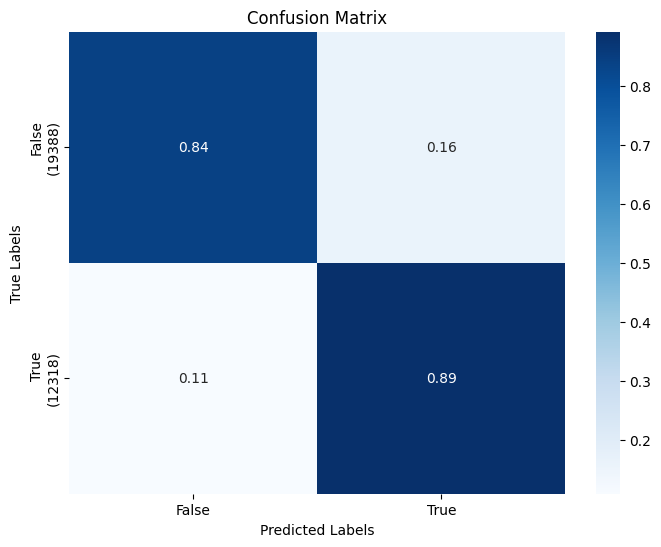

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert data to PyTorch tensors
test_data_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
test_labels_tensor = torch.tensor(y_test, dtype=torch.long)

model = model.to(device)

# Define dataset and DataLoader for test data
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=1024)

# Load the best model saved during training
model.load_state_dict(torch.load('best_model_'+label+'.pth'))
model.eval()  # Set model to evaluation mode

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test DataLoader
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # Apply sigmoid function to logits
        probabilities = torch.sigmoid(outputs)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(probabilities.cpu().numpy())

# Calculate evaluation metric
predicted_labels = np.array(predicted_labels)
predicted_labels =(predicted_labels > 0.5).astype(int)
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='binary')
recall = recall_score(true_labels, predicted_labels, average='binary')
f1 = f1_score(true_labels, predicted_labels,average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
classes =  ['False', 'True']
classes_y = []
class_counts = np.bincount(true_labels)
for i, count in enumerate(class_counts):
    classes_y.append(classes[i] + '\n(' + str(count) + ')')
cm = confusion_matrix(true_labels,predicted_labels, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes_y)


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
